In [47]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from scipy.integrate import quad

In [48]:
# relevant constants

c = 3e10
k = 1.381e-16
pc = 3.086e18

Jy = 1e-23 # erg s^-1 cm^-2 Hz^-1

In [49]:
# function describing sky brightness, based on sky coordinates, 
# geometry of disk/halo, and power densities of each
# l and b given in degrees (as from hp.pix2ang) - convert to radians
# d = distance of sun from center of galaxy

def LineOfSightDisk(l, b, d, R_disk, h_disk):
    
    # first calculate length of line of sight through disk
    
    l = np.deg2rad(l)
    b = np.deg2rad(b)

    l = np.min([l, (2*np.pi)-l])
    b = np.abs(b)
    B_disk = np.pi - l - np.arcsin((d/R_disk)*np.sin(l))
    r_disk = np.sqrt((R_disk**2) + (d**2) - (2*R_disk*d*np.cos(B_disk)))
    
    if b <= np.arctan(0.5*h_disk/r_disk):
        D_disk = r_disk/(np.cos(b))
        
    else: 
        D_disk = 0.5*h_disk/(np.sin(b))
        
    return D_disk
        

def LineOfSightHalo(l, b, d, R_halo):  
    
    # next calculate length of line of sight through halo
    
    l = np.deg2rad(l)
    b = np.deg2rad(b)
    
    l = np.min([l, (2*np.pi)-l])
    b = np.abs(b)
    
    b_ = np.pi - b
    
    d_proj = d*np.abs(np.cos(l))
    B_halo1 = np.pi - l - np.arcsin((d/R_halo)*np.sin(l))
    
    if l > np.pi/2:
        b = b_
        R_eff = np.sqrt((R_halo**2) + (d**2) - (2*R_halo*d*np.cos(B_halo1))) + d_proj
        
    else: 
        R_eff = np.sqrt((R_halo**2) + (d**2) - (2*R_halo*d*np.cos(B_halo1))) - d_proj
    
    B_halo = np.pi - b - np.arcsin((d_proj/R_eff)*np.sin(b))
    
    D_tot = np.sqrt((R_eff**2) + (d_proj**2) - (2*R_eff*d_proj*np.cos(B_halo)))
    D_halo = D_tot
    
    if D_halo < 0:
        D_halo = 0
    
    return D_halo

def SkyBrightness(D_disk, D_halo, p_disk, p_halo):
    
        
    # flux density (erg s^-1 cm^-2 Hz^-1) = power density * distance 
    F = p_disk*D_disk + p_halo*D_halo
    
    return F
    
   
        
    

In [50]:
# get coordinates for each pixel of a map of a given size
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)
# number of steradians per pixel
sr = hp.nside2pixarea(NSIDE)
m = np.arange(NPIX)
coords = hp.pix2ang(NSIDE, m, lonlat=True)
l = coords[0]
b = coords[1]

1.0411715987433933e-41
5.249652526505947e-41
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


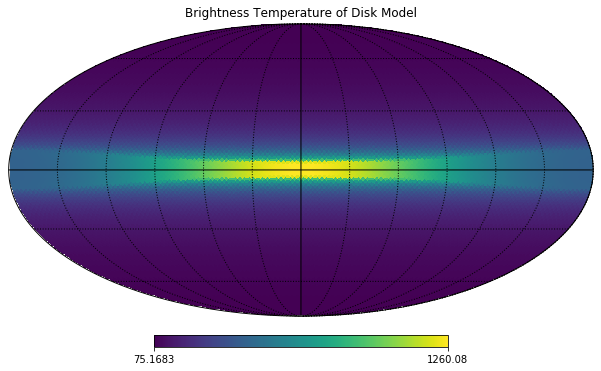

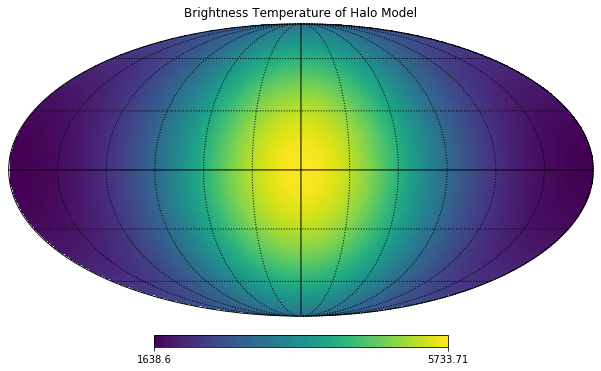

In [51]:
# 1420 MHz values taken from Subrahmanyan paper
# all distances in paper given in units of the solar circle

nu = 1420e6
T_disk = 0.79 # defined at poles
T_halo = 0.3
d = 8e3*pc # distance from galactic center to sun ~8kpc
R_disk = 2.1*d
h_disk = 0.37*d
R_halo = 1.8*d

# need to verify this calculation is correct
p_disk = 4*np.pi*np.arctan(0.5*h_disk/R_disk)*(2*(nu**2)/c**2)*k*T_disk*(1/R_disk)
p_halo = (4*np.pi)*(2*(nu**2)/c**2)*k*T_halo*(1/R_halo)

print(p_disk)
print(p_halo)

pix_disk = []
pix_halo = []
d_disk = []
d_halo = []

for i in np.arange(NPIX):
    
    los_disk = LineOfSightDisk(l[i], b[i], d, R_disk, h_disk)
    los_halo = LineOfSightHalo(l[i], b[i], d, R_halo)
    
    d_disk.append(los_disk)
    d_halo.append(los_halo)
    
    pix_disk.append(los_disk*p_disk)
    pix_halo.append(los_halo*p_halo)


    
pix_disk = np.array(pix_disk)
T_disk = np.array([(f/sr)*(c**2)/(2*k*(nu**2)) for f in pix_disk])
pix_halo = np.array(pix_halo)
T_halo = np.array([(f/sr)*(c**2)/(2*k*(nu**2)) for f in pix_halo])

hp.mollview(T_disk, title="Brightness Temperature of Disk Model")
hp.graticule()
plt.savefig('notes/disk.jpg')

hp.mollview(T_halo, title = "Brightness Temperature of Halo Model")
hp.graticule()
plt.savefig('notes/halo.jpg')

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


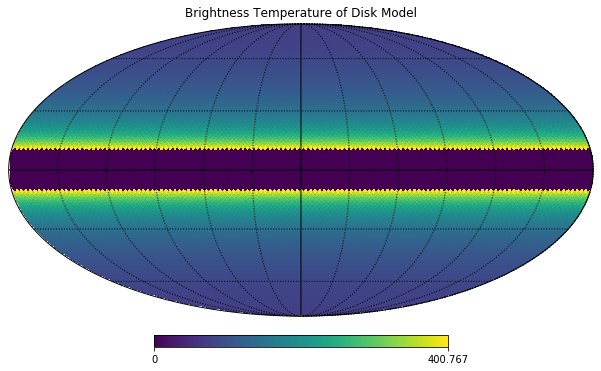

In [52]:
# Mask all pixels between -10 < b < +10 by setting them all to zero

idx = hp.query_strip(NSIDE, np.deg2rad(90-10), np.deg2rad(90+10))
pix_disk[idx] = 0
T_disk[idx] = 0

hp.mollview(T_disk, title="Brightness Temperature of Disk Model")
hp.graticule()
plt.savefig('notes/disk_mod.jpg')

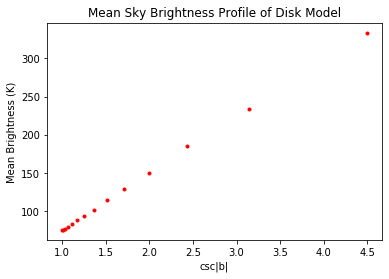

In [53]:
# Construact a T_b vs csc(b) graph

b_range = np.linspace(10,90,15)

cscb = []
Tb = []

for i in range(len(b_range)-1):
    
    b1 = 90 - b_range[i]
    b2 = 90 - b_range[i+1]
    
    bmid = 0.5*(b_range[i] + b_range[1+i])
    
    cscb.append(1/(np.sin(np.deg2rad(bmid)))) 
    
    idx = hp.query_strip(NSIDE, np.deg2rad(b2), np.deg2rad(b1))
    I_v = np.mean(pix_disk[idx])/sr
    
    T = I_v*c**2/(2*k*nu**2)
    Tb.append(T)

plt.figure(0)
plt.plot(cscb,Tb,'r.')
plt.xlabel('csc|b|')
plt.ylabel('Mean Brightness (K)')
plt.title('Mean Sky Brightness Profile of Disk Model')
plt.savefig('notes/cscb.jpg')

    
    

In [54]:
# Extragalactic source contribution 

a = -0.7 # spectral index

nu = 1420e6

In [55]:
## contribution from 0.05 to 1000 mJy - see Hopkins et al 2002 ##

nu1 = 1420e6

S_low1 = (0.05*1e-3)*(nu/(nu1))**a
S_up1 = (1000*1e-3)*(nu/(nu1))**a


def Hopkins2002(S):
    
    # S in Jy
    x = np.log10(S*1000)
    
    F = -0.008*x**6 + 0.057*x**5 - 0.121*x**4 - 0.049*x**3 + 0.376*x**2 + 0.508*x + 0.859
    G = (10**F)*(S**-1.5)
    
    return G

S1 = quad(Hopkins2002, S_low1, S_up1)

#S1 = S1_1420[0]*(nu/(nu1))**a # convert everything to freq in question

print(S1[0]) # Jy/sr  


4512.449118641871


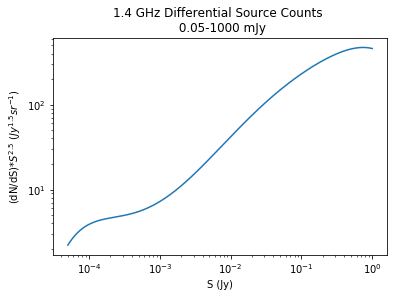

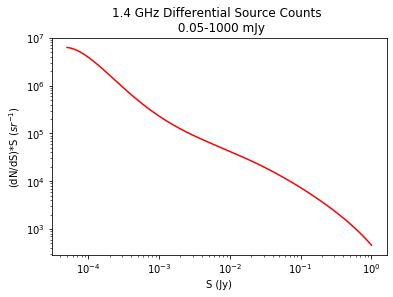

In [56]:
# verify behavior of function in Hopkins 2012

N = np.logspace(np.log10(0.05/1000), np.log10(1000/1000), 500)
Y = []
YY = []

for S in N:
    
    x = np.log10(S*1000)
    
    F = -0.008*x**6 + 0.057*x**5 - 0.121*x**4 - 0.049*x**3 + 0.376*x**2 + 0.508*x + 0.859
    G = (10**F)*(S**-1.5)
    
    Y.append(10**F)
    YY.append(G)
    
plt.figure(5)
plt.plot(N,Y)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('S (Jy)')
plt.ylabel('(dN/dS)*$S^{2.5}$ ($Jy^{1.5}sr^{-1}$)')
plt.title('1.4 GHz Differential Source Counts \n 0.05-1000 mJy')
plt.savefig('notes/Hopkins1.jpg')

plt.figure(6)
plt.plot(N,YY, 'r-')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('(dN/dS)*S ($sr^{-1}$)')
plt.xlabel('S (Jy)')
plt.title('1.4 GHz Differential Source Counts \n 0.05-1000 mJy')
plt.savefig('notes/Hopkins2.jpg')

3609.3997100859333


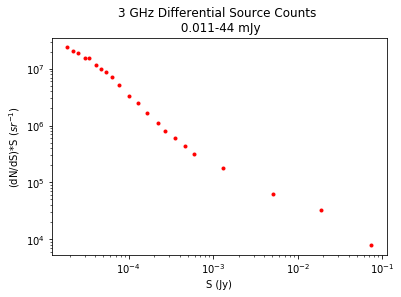

In [57]:
## contribution from 0.011 to 44 mJy - see Smolcic et al 2017 ##

## can use this to also verify that the integrated brightness 
#  calculated in the Hopkins 2012 paper is consistent?? ##

nu2 = 3e9
S_range2 = [0.011, 0.013, 0.015, 0.018, 0.020, 0.024, 0.028,
            0.032, 0.037, 0.045, 0.059, 0.076, 0.098, 0.13, 0.16,
            0.21, 0.27, 0.35, 0.78, 3.0, 11, 44] # in mJy

counts2 = [0.866, 0.952, 1.10, 1.16, 1.40, 1.38, 1.47, 1.57, 1.59,
           1.58, 1.53, 1.67, 1.60, 1.65, 1.62, 1.82, 1.93, 2.03, 3.95,
           10.4, 37.4, 72.3] # in Jy^1.5 sr^-1

S_range2 = [s/1000 for s in S_range2]

for i in range(len(S_range2)):
    
    counts2[i] = counts2[i]/(S_range2[i]**1.5)
    
S_range2 = [s*(nu/(nu2))**a for s in S_range2]
    
S2 = np.trapz(counts2, S_range2) # Jy/sr

#S2 = S2_*(nu/(nu2))**a #convert to frequency of interest (nu)
print(S2)

plt.plot(S_range2, counts2, 'r.')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('(dN/dS)*S ($sr^{-1}$)')
plt.xlabel('S (Jy)')
plt.title('3 GHz Differential Source Counts \n 0.011-44 mJy')
plt.savefig('notes/Smolcic.jpg')

In [58]:
## compare range that overlaps between Hopkins and Smolcic papers

t1 = quad(Hopkins2002, .059/1000, 44/1000)
t2 = np.trapz(counts2[10::], S_range2[10::])*(nu/(nu2))**a

print(t1[0])
print(t2)

# from this, seems like Smolcic data points predit larger brightness 
# than the Hopkins function? 

2344.570408839439
4812.2061643287625


(554.4721285267351, 7.888600585658628e-07)


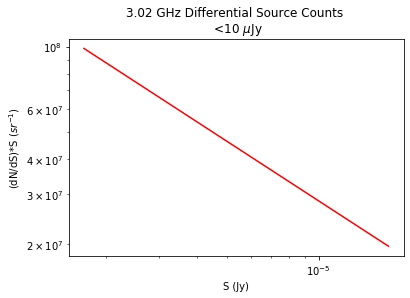

In [59]:
## contribution from 1 < S < 10 microJy sources - see Condon et al 2012 ##
nu3 = 3.02e9
S_low3 = (1/1e6)*(nu/(nu3))**a
S_up3 = (10/1e6)*(nu/(nu3))**a

def Condon2012(S):
    # S in Jy
    n = 9000*(S**-1.7)
    return n*S

t3 = quad(Condon2012, S_low3, S_up3)
#t3 = t3_[0]*(nu/(nu3))**a # convert to freq of interest (nu)
print(t3)

X3 = np.linspace(S_low3,S_up3, 500)
Y3 = [Condon2012(x) for x in X3]

plt.plot(X3, Y3, 'r-')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('(dN/dS)*S ($sr^{-1}$)')
plt.xlabel('S (Jy)')
plt.title('3.02 GHz Differential Source Counts \n <10 $\mu$Jy')
plt.savefig('notes/Condon.jpg', bbox_inches = "tight")

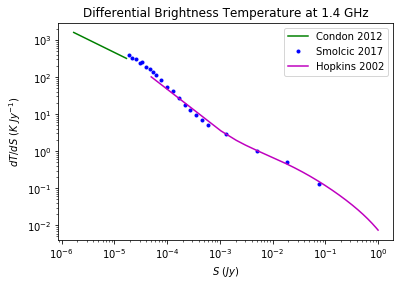

In [60]:
## Put all of the source counts together ##

plt.figure()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$S\ (Jy)$')
plt.ylabel('$dT/dS\ (K\ Jy^{-1})$')

S1 = np.linspace(S_low1, S_up1, 1000)
dTdS1 = [Hopkins2002(s)*Jy*(c**2)/(2*k*(nu**2)) for s in S1]

S2 = S_range2
dTdS2 = [x*Jy*(c**2)/(2*k*(nu**2)) for x in counts2]

S3 = np.linspace(S_low3, S_up3, 1000)
dTdS3 = [Condon2012(s)*Jy*(c**2)/(2*k*(nu**2)) for s in S3]

plt.plot(S3, dTdS3, 'g-', label="Condon 2012")
plt.plot(S2, dTdS2, 'b.', label="Smolcic 2017")
plt.plot(S1, dTdS1, 'm-', label="Hopkins 2002")

plt.legend()

plt.title("Differential Brightness Temperature at 1.4 GHz")
plt.savefig('notes/T_b.jpg')

In [61]:
idx = 0
for s in S2:
    if s < S_low1:
        idx+=1
        
T1 = quad(Hopkins2002, S2[idx], S_up1)[0]*Jy*(c**2)/(2*k*(nu**2))
T2 = np.trapz(dTdS2[0:idx], S2[0:idx])
T3 = quad(Condon2012, S_low3, S_up3)[0]*Jy*(c**2)/(2*k*(nu**2))

T = T1 + T2 + T3
# print(T1)
# print(T2)
# print(T3)
print(T) # in Kelvin

0.0886647260992252
